In [1]:
# ==================== Reproducibilidad ====================
import random
import numpy as np
import torch
import re
from bs4 import BeautifulSoup
from langdetect import detect, DetectorFactory
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

DetectorFactory.seed = 0
set_seed = lambda seed=42: [random.seed(seed), np.random.seed(seed), torch.manual_seed(seed), torch.cuda.manual_seed_all(seed), setattr(torch.backends.cudnn, 'deterministic', True), setattr(torch.backends.cudnn, 'benchmark', False)]
set_seed()


c:\Users\Jhonr\anaconda3\envs\Entorno_Sugerido_NPL_jl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[None, None, <torch._C.Generator at 0x21e5bd837f0>, None, None, None]

In [2]:
# ==================== Funciones de preprocesamiento ====================
def es_ingles(texto):
    try:
        return detect(texto) == 'en'
    except:
        return False

def limpiar_texto(texto):
    if not texto or texto.strip() == '':
        return 'Texto vacío'
    texto_limpio = BeautifulSoup(texto, "html.parser").get_text()
    texto_limpio = texto_limpio.lower()
    texto_limpio = re.sub(r'^(introduction|aims|objectives|methods|results|discussion|conclusion):\s*', '', texto_limpio, flags=re.IGNORECASE)
    texto_limpio = re.sub(r'\b(notwithstanding|this paper aims|to evaluate|previous studies suggest that|the purpose of this study is)\b', '', texto_limpio)
    texto_limpio = re.sub(r'[^a-z0-9\s,.]', '', texto_limpio)
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
    return texto_limpio

In [3]:
# ==================== Cargar y preparar dataset ====================
file_path = r"C:\\Users\\Jhonr\\Project_ODS_BERT\\Muestra_Limpia_ODS_3_9_Otros.xlsx"
df = pd.read_excel(file_path)
df = df[df["ODS"].isin(["ODS 3", "ODS 9", "OTROS"])]
df["ODS_BINARIA"] = df["ODS"].apply(lambda x: "ODS 3" if x == "ODS 3" else "NO ODS 3")
df['Abstract_Limpio'] = df['Abstract'].apply(lambda x: limpiar_texto(x) if es_ingles(x) else None)
df = df.dropna(subset=['Abstract_Limpio'])

textos = df["Abstract_Limpio"].tolist()
etiquetas = df["ODS_BINARIA"].tolist()

In [4]:
# ==================== Codificar etiquetas ====================
label_encoder = LabelEncoder()
labels_codificados = label_encoder.fit_transform(etiquetas)
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {v: k for k, v in id2label.items()}

# ==================== División de datos ====================
X_train, X_val, y_train, y_val = train_test_split(
    textos, labels_codificados, test_size=0.2, random_state=42, stratify=labels_codificados
)

In [5]:
# ==================== Dataset para BERT ====================
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class ODSDataset(Dataset):
    def __init__(self, textos, etiquetas):
        self.encodings = tokenizer(textos, truncation=True, padding="max_length", max_length=256)
        self.labels = etiquetas

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = ODSDataset(X_train, y_train)
val_dataset = ODSDataset(X_val, y_val)


c:\Users\Jhonr\anaconda3\envs\Entorno_Sugerido_NPL_jl\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# ==================== Modelo y entrenamiento ====================
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_encoder.classes_),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir=f"./resultados_bert_ods3",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    seed=42,
    logging_dir=f"./logs_bert_ods3",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Jhonr\anaconda3\envs\Entorno_Sugerido_NPL_jl\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 19%|█▉        | 26/135 [00:10<00:36,  3.01it/s]c:\Users\Jhonr\anaconda3\envs\Entorno_Sugerido_NPL_jl\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 20%|██        | 27/

{'eval_loss': 0.485706090927124, 'eval_accuracy': 0.6226415094339622, 'eval_precision': 0.3876824492702029, 'eval_recall': 0.6226415094339622, 'eval_f1': 0.4778411584028082, 'eval_runtime': 0.7161, 'eval_samples_per_second': 74.012, 'eval_steps_per_second': 9.775, 'epoch': 1.0}


                                                
 40%|████      | 54/135 [00:22<00:27,  2.99it/s]

{'eval_loss': 0.3289452791213989, 'eval_accuracy': 0.9245283018867925, 'eval_precision': 0.9245283018867925, 'eval_recall': 0.9245283018867925, 'eval_f1': 0.9245283018867925, 'eval_runtime': 0.7206, 'eval_samples_per_second': 73.545, 'eval_steps_per_second': 9.714, 'epoch': 2.0}


                                                
 60%|██████    | 81/135 [00:34<00:17,  3.00it/s]

{'eval_loss': 0.2968098521232605, 'eval_accuracy': 0.9245283018867925, 'eval_precision': 0.9245283018867925, 'eval_recall': 0.9245283018867925, 'eval_f1': 0.9245283018867925, 'eval_runtime': 0.72, 'eval_samples_per_second': 73.615, 'eval_steps_per_second': 9.723, 'epoch': 3.0}


                                                 
 80%|████████  | 108/135 [00:47<00:09,  2.98it/s]

{'eval_loss': 0.35153108835220337, 'eval_accuracy': 0.8867924528301887, 'eval_precision': 0.891218945388148, 'eval_recall': 0.8867924528301887, 'eval_f1': 0.8877190026954178, 'eval_runtime': 0.7153, 'eval_samples_per_second': 74.091, 'eval_steps_per_second': 9.786, 'epoch': 4.0}


                                                 
100%|██████████| 135/135 [01:00<00:00,  3.00it/s]

{'eval_loss': 0.3298443853855133, 'eval_accuracy': 0.8867924528301887, 'eval_precision': 0.891218945388148, 'eval_recall': 0.8867924528301887, 'eval_f1': 0.8877190026954178, 'eval_runtime': 0.7052, 'eval_samples_per_second': 75.152, 'eval_steps_per_second': 9.926, 'epoch': 5.0}


100%|██████████| 135/135 [01:05<00:00,  2.05it/s]

{'train_runtime': 65.8437, 'train_samples_per_second': 15.871, 'train_steps_per_second': 2.05, 'train_loss': 0.22357717443395544, 'epoch': 5.0}


TrainOutput(global_step=135, training_loss=0.22357717443395544, metrics={'train_runtime': 65.8437, 'train_samples_per_second': 15.871, 'train_steps_per_second': 2.05, 'total_flos': 137475526425600.0, 'train_loss': 0.22357717443395544, 'epoch': 5.0})

100%|██████████| 7/7 [00:00<00:00, 12.10it/s]



Reporte de clasificación (modelo ODS 3):
              precision    recall  f1-score   support

    NO ODS 3       0.90      0.90      0.90        20
       ODS 3       0.94      0.94      0.94        33

    accuracy                           0.92        53
   macro avg       0.92      0.92      0.92        53
weighted avg       0.92      0.92      0.92        53



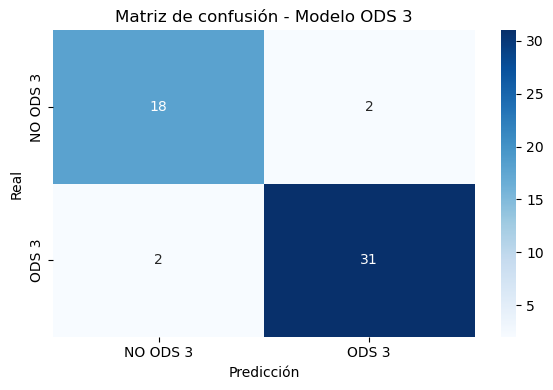

In [7]:
# ==================== Evaluación final ====================
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

print("\nReporte de clasificación (modelo ODS 3):")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Matriz de confusión - Modelo ODS 3")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [8]:
# ==================== Guardar modelo ====================
modelo_path = r"C:\\Users\\Jhonr\\Project_ODS_BERT\\Modelos\\BERT_ODS3_Medicina"
model.save_pretrained(modelo_path)
tokenizer.save_pretrained(modelo_path)

('C:\\\\Users\\\\Jhonr\\\\Project_ODS_BERT\\\\Modelos\\\\BERT_ODS3_Medicina\\tokenizer_config.json',
 'C:\\\\Users\\\\Jhonr\\\\Project_ODS_BERT\\\\Modelos\\\\BERT_ODS3_Medicina\\special_tokens_map.json',
 'C:\\\\Users\\\\Jhonr\\\\Project_ODS_BERT\\\\Modelos\\\\BERT_ODS3_Medicina\\vocab.txt',
 'C:\\\\Users\\\\Jhonr\\\\Project_ODS_BERT\\\\Modelos\\\\BERT_ODS3_Medicina\\added_tokens.json',
 'C:\\\\Users\\\\Jhonr\\\\Project_ODS_BERT\\\\Modelos\\\\BERT_ODS3_Medicina\\tokenizer.json')